### Imports

In [180]:
import gymnasium as gym
import numpy as np
import random
import tqdm
import imageio
import os

from IPython.display import Image

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

#### Q-Learning

In [181]:
env = gym.make("Taxi-v3", render_mode="rgb_array") # rgb_array / ainsi

In [182]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")
# 500 états possbiles (500 lignes)

action_space = env.action_space.n
print("There are ", action_space, " possible actions")
# 6 actions possibles (6 colonnes)

There are  500  possible states
There are  6  possible actions


In [183]:
def initialize_q_table(state_space, action_space):
    Qtable = np.zeros((state_space, action_space))
    return Qtable

In [184]:
Qtable_taxi = initialize_q_table(state_space, action_space)
print(Qtable_taxi)
print("Q-table shape: ", Qtable_taxi.shape)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Q-table shape:  (500, 6)


#### Greedy policy

In [185]:
def greedy_policy(Qtable, state):
    # Exploitation: take the action with the highest state, action value
    action = np.argmax(Qtable[state][:])

    return action

#### Epsilon greedy policy

In [186]:
def epsilon_greedy_policy(Qtable, state, epsilon):
    # Randomly generate a number between 0 and 1
    random_num = random.uniform(0, 1)
    # if random_num > greater than epsilon --> exploitation
    if random_num > epsilon:
        # Take the action with the highest value given a state
        # np.argmax can be useful here
        action = greedy_policy(Qtable, state)
    # else --> exploration
    else:
        action = env.action_space.sample()

    return action

#### Hyperparameters

In [187]:
# Training parameters
n_training_episodes = 30000
learning_rate = 0.7

# Evaluation parameters
n_eval_episodes = 100

# DO NOT MODIFY EVAL_SEED
eval_seed = [
    16,
    54,
    165,
    177,
    191,
    191,
    120,
    80,
    149,
    178,
    48,
    38,
    6,
    125,
    174,
    73,
    50,
    172,
    100,
    148,
    146,
    6,
    25,
    40,
    68,
    148,
    49,
    167,
    9,
    97,
    164,
    176,
    61,
    7,
    54,
    55,
    161,
    131,
    184,
    51,
    170,
    12,
    120,
    113,
    95,
    126,
    51,
    98,
    36,
    135,
    54,
    82,
    45,
    95,
    89,
    59,
    95,
    124,
    9,
    113,
    58,
    85,
    51,
    134,
    121,
    169,
    105,
    21,
    30,
    11,
    50,
    65,
    12,
    43,
    82,
    145,
    152,
    97,
    106,
    55,
    31,
    85,
    38,
    112,
    102,
    168,
    123,
    97,
    21,
    83,
    158,
    26,
    80,
    63,
    5,
    81,
    32,
    11,
    28,
    148,
]  # Evaluation seed, this ensures that all classmates agents are trained on the same taxi starting position
# Each seed has a specific starting state

# Environment parameters
env_id = "Taxi-v3"  # Name of the environment
max_steps = 99  # Max steps per episode
gamma = 0.95  # Discounting rate

# Exploration parameters
max_epsilon = 1.0  # Exploration probability at start
min_epsilon = 0.05  # Minimum exploration probability
decay_rate = 0.005  # Exponential decay rate for exploration prob

#### Train the Q-Learning agent

In [188]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    for episode in tqdm(range(n_training_episodes)):
        # Reduce epsilon (because we need less and less exploration)
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        # Reset the environment
        state, info = env.reset()
        step = 0
        terminated = False
        truncated = False

        for step in range(max_steps):
            # Choose the action At using epsilon greedy policy
            action = epsilon_greedy_policy(Qtable, state, epsilon)

            # Take action At and observe Rt+1 and St+1
            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, terminated, truncated, info = env.step(action)

            # Décomposition de l’état en ses composantes
            taxi_row, taxi_col, passenger_location, destination = env.unwrapped.decode(new_state)

            ## Code to add to change reward values

            # pickup_locations = [0, 1, 2, 3]  # 4 emplacements possibles pour récupérer un passager
            # destination_state = destination  # Destination finale
            # pickup_state = passenger_location  # Position actuelle du passager

            # print("pickup_locations: ", pickup_locations)
            # print("destination_state: ", destination_state)
            # print("pickup_state: ", pickup_state)

            # # ✅ Modification des récompenses pour accélérer l'apprentissage
            # if passenger_location == 4 and new_state == destination:  
            #     reward += 30  # 🎯 Récompenser fortement la livraison du passager
            # elif passenger_location in pickup_locations and action == 4:  
            #     reward += 5   # 🚖 Récompenser la récupération d’un passager
            # elif action in [4, 5] and passenger_location != 4:  
            #     reward -= 10  # ❌ Punir les mauvaises tentatives de prise/dépose
            # elif reward == -1:
            #     reward -= 2   # ⏳ Augmenter la pénalité des actions inutiles

            # print("reward: ", reward)

            ## Code to add to change reward values

            # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            Qtable[state][action] = Qtable[state][action] + learning_rate * (
                reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action]
            )

            # If terminated or truncated finish the episode
            if terminated or truncated:
                break

            # Our next state is the new state
            state = new_state
    return Qtable

In [189]:
Qtable_taxi = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_taxi)
Qtable_taxi

  0%|          | 0/30000 [00:00<?, ?it/s]

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  2.75200358,   3.94947757,   0.53368333,   3.94947756,
          5.20997639,  -5.05052243],
       [  7.93349183,   9.40367562,   7.93349184,   9.40367562,
         10.9512375 ,   0.40367562],
       ...,
       [  6.6848941 ,  12.58025   ,   6.76860063,  -2.27104675,
        -11.38270126, -10.16203825],
       [ -4.58350316,   6.53681725,  -4.13917823,  -4.72143865,
        -12.85513293, -10.6447075 ],
       [  9.98264777,   9.48045931,  15.6464    ,  18.        ,
         -7.        ,   4.96127345]])

#### Evaluation

In [190]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):
    """
    Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
    :param env: The evaluation environment
    :param n_eval_episodes: Number of episode to evaluate the agent
    :param Q: The Q-table
    :param seed: The evaluation seed array (for taxi-v3)
    """
    episode_rewards = []
    episode_steps = []
    for episode in tqdm(range(n_eval_episodes)):
        if seed:
            state, info = env.reset(seed=seed[episode])
        else:
            state, info = env.reset()
        step = 0
        truncated = False
        terminated = False
        total_rewards_ep = 0

        for step in range(max_steps):
            # Take the action (index) that have the maximum expected future reward given that state
            action = greedy_policy(Q, state)
            new_state, reward, terminated, truncated, info = env.step(action)
            total_rewards_ep += reward

            if terminated or truncated:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)
        episode_steps.append(step + 1)

    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    avg_steps = np.mean(episode_steps)

    return mean_reward, std_reward, avg_steps

In [191]:
mean_reward, std_reward, avg_steps = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_taxi, eval_seed)
print("\n🔎 **Evaluate Q-Learning agent** 🔎")
print(f"🎯 Mean reward={mean_reward:.2f} +/- {std_reward:.2f}")
print(f"🚶‍♂️ Moyenne des étapes : {avg_steps:.2f}")


  0%|          | 0/100 [00:00<?, ?it/s]


🔎 **Evaluate Q-Learning agent** 🔎
🎯 Mean reward=7.48 +/- 2.63
🚶‍♂️ Moyenne des étapes : 13.52


#### Learning curve training episodes

In [ ]:
training_episodes_list = [5000, 10000, 20000, 30000, 40000, 50000]
mean_rewards = []

for n_training_episodes in training_episodes_list:
    Qtable_taxi = np.zeros((env.observation_space.n, env.action_space.n))
    Qtable_taxi = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_taxi)
    mean_reward, std_reward, avg_steps = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_taxi, eval_seed)
    mean_rewards.append(mean_reward)
    print(f"Training episodes: {n_training_episodes}, Mean reward: {mean_reward:.2f}, Mean steps: {avg_steps:.2f}")

plt.plot(training_episodes_list, mean_rewards, marker='o')
plt.xticks(training_episodes_list)
plt.xlabel('Number of Training Episodes')
plt.ylabel('Mean Reward')
plt.title('Mean Reward vs. Number of Training Episodes')
plt.grid(True)
plt.show()

#### Record video function

In [193]:
def record_video(env, Qtable, video_path, num_episodes=1):
    images = []
    for episode in range(num_episodes):
        state, info = env.reset()
        done = False
        img = env.render()
        images.append(img)
        while not done:
            action = np.argmax(Qtable[state])
            state, reward, done, truncated, info = env.step(action)
            img = env.render()
            images.append(img)
    imageio.mimsave(video_path, images)

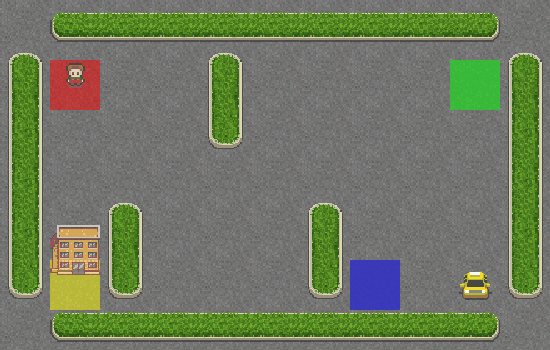

In [194]:
# Définir le répertoire de sortie pour la vidéo
output_dir = "videos"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Enregistrer la vidéo
video_path = os.path.join(output_dir, "taxi_agent.gif")
record_video(env, Qtable_taxi, video_path, 5)

Image(video_path)

#### Display model

In [195]:
model = {
    "env_id": env_id,
    "max_steps": max_steps,
    "n_training_episodes": n_training_episodes,
    "n_eval_episodes": n_eval_episodes,
    # "eval_seed": eval_seed,
    "learning_rate": learning_rate,
    "gamma": gamma,
    "max_epsilon": max_epsilon,
    "min_epsilon": min_epsilon,
    "decay_rate": decay_rate,
    "qtable": Qtable_taxi,
}

model

{'env_id': 'Taxi-v3',
 'max_steps': 99,
 'n_training_episodes': 30000,
 'n_eval_episodes': 100,
 'learning_rate': 0.7,
 'gamma': 0.95,
 'max_epsilon': 1.0,
 'min_epsilon': 0.05,
 'decay_rate': 0.005,
 'qtable': array([[  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ],
        [  2.75200358,   3.94947757,   0.53368333,   3.94947756,
           5.20997639,  -5.05052243],
        [  7.93349183,   9.40367562,   7.93349184,   9.40367562,
          10.9512375 ,   0.40367562],
        ...,
        [  6.6848941 ,  12.58025   ,   6.76860063,  -2.27104675,
         -11.38270126, -10.16203825],
        [ -4.58350316,   6.53681725,  -4.13917823,  -4.72143865,
         -12.85513293, -10.6447075 ],
        [  9.98264777,   9.48045931,  15.6464    ,  18.        ,
          -7.        ,   4.96127345]])}

#### Test different hyperparameters

In [196]:
# Liste de configurations à tester
param_tests = [
    {"learning_rate": 0.1, "gamma": 0.8, "decay_rate": 0.01},  # Faible apprentissage et gamma bas
    {"learning_rate": 0.5, "gamma": 0.95, "decay_rate": 0.005},  # Config actuelle
    {"learning_rate": 0.9, "gamma": 0.99, "decay_rate": 0.001},  # Apprentissage agressif, gamma fort
]

# Stocker les résultats
results = []

for params in param_tests:
    print(f"\n🔹 Test avec α={params['learning_rate']}, γ={params['gamma']}, ε-decay={params['decay_rate']}")

    # Réinitialiser la Q-table
    Qtable_test = initialize_q_table(state_space, action_space)

    # Entraînement avec les nouveaux paramètres
    Qtable_test = train(n_training_episodes, min_epsilon, max_epsilon, params["decay_rate"], 
                        env, max_steps, Qtable_test)

    # Évaluation de l'agent
    mean_reward, std_reward, avg_steps = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_test, eval_seed)

    # Stocker les résultats
    results.append((params, mean_reward, avg_steps))

# Afficher les résultats comparatifs
print("\n📊 **Comparaison des Hyperparamètres**")
for params, mean_reward, avg_steps in results:
    print(f"α={params['learning_rate']}, γ={params['gamma']}, ε-decay={params['decay_rate']} → "
          f"Reward moy={mean_reward:.2f}, Steps moy={avg_steps:.2f}")



🔹 Test avec α=0.1, γ=0.8, ε-decay=0.01


  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


🔹 Test avec α=0.5, γ=0.95, ε-decay=0.005


  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


🔹 Test avec α=0.9, γ=0.99, ε-decay=0.001


  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


📊 **Comparaison des Hyperparamètres**
α=0.1, γ=0.8, ε-decay=0.01 → Reward moy=7.54, Steps moy=13.46
α=0.5, γ=0.95, ε-decay=0.005 → Reward moy=7.50, Steps moy=13.50
α=0.9, γ=0.99, ε-decay=0.001 → Reward moy=7.56, Steps moy=13.44


Un α trop bas (0.1) peut rendre l’apprentissage trop lent.

Un γ trop élevé (0.99) peut donner trop d’importance aux récompenses futures et ralentir l’adaptation.

Un ε-decay trop rapide peut arrêter l’exploration trop tôt.

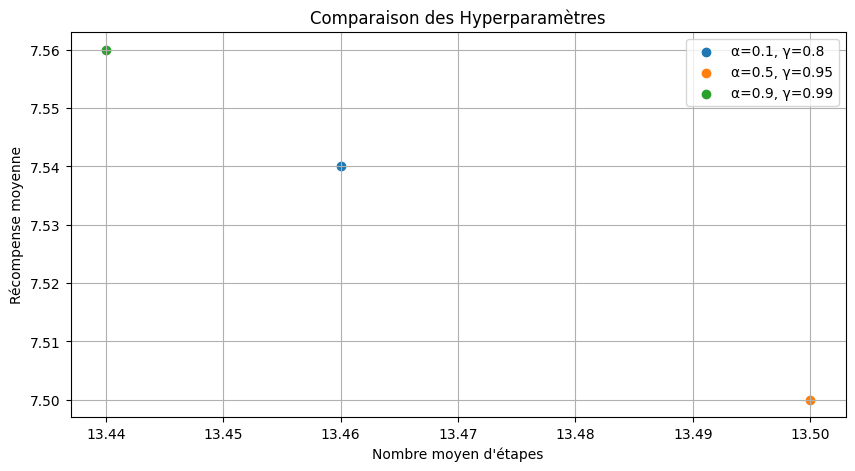

In [197]:
# Tracer les récompenses moyennes par configuration
plt.figure(figsize=(10, 5))

for params, mean_reward, avg_steps in results:
    plt.scatter(avg_steps, mean_reward, label=f"α={params['learning_rate']}, γ={params['gamma']}")

plt.xlabel("Nombre moyen d'étapes")
plt.ylabel("Récompense moyenne")
plt.title("Comparaison des Hyperparamètres")
plt.legend()
plt.grid()
plt.show()